In [1]:
#Moon centered J2000 ephemeris model 
#ephemeris sim
using LinearAlgebra
#make sure to cite this package
using SPICE
using Downloads: download 
using DifferentialEquations
using Plots

In [2]:
# Load leap seconds kernel (desktop)
furnsh("/home/faustovega/Desktop/astrodynamics_nasa_work/naif0012.tls")

# laptop 

# furnsh("/home/fausto/naif0012.tls")

In [3]:
# Convert the calendar date to ephemeris seconds past J2000
et = 0

#et = utc2et("2024-02-06T20:45:00")

0

In [4]:
# Load a planetary ephemeris kernel
furnsh("/home/faustovega/Desktop/astrodynamics_nasa_work/de440.bsp")

#furnsh("/home/fausto/de440.bsp")

In [5]:
#gravitational parameters for the bodies (km3/s2)

#moon 
μ_m = 4902.80058214776

#earth
μ_e = 398600.432896939

#sun
μ_s = 132712440017.987

1.32712440017987e11

In [6]:
#units used to normalize
#also in km and seconds

#distance
l_star = 385692.50

#time
t_star = 377084.152667038

#in km
lunar_radius = 1738.2 

1738.2

In [7]:
#get the jacobian that maps from rotating frame to inertial frame
function get_transformation(time)

    #time is already wrt et
    
    #state of the Earth (position and velocity) relative to moon (in km and km/s)
    earth_state = spkezr("earth",time,"J2000","NONE","moon")[1]

    #position of the Earth relative to the moon
    r_earth = earth_state[1:3]

    #velocity of the Earth relative to moon
    v_earth = earth_state[4:6]

    #x component of the rotating frame expressed in inertial coordinates
    x̃ = r_earth/norm(r_earth)
    #z component of the rotating frame expressed in inertial coordinates
    z̃ = cross(r_earth, v_earth)/norm(cross(r_earth, v_earth))
    #x component of the rotating frame expressed in inertial coordinates
    ỹ = cross(z̃, x̃)

    #instantanous rotation matrix from rotating frame to inertial frame (centered at moon)
    C = [x̃ ỹ z̃]

    #instantanous angular velocity
    #θ_dot = norm(cross(r_moon, v_moon))/(norm(r_moon)^2)

    θ_dot = (cross(r_earth, v_earth)/(norm(r_earth)^2))[3]


    return C, θ_dot

end

get_transformation (generic function with 1 method)

In [8]:
#ensure x is dimensional (km and seconds)
function cr3bp_to_ephem(x, t)

    time = et + t

    #get transformation takes in time wrt et
    C, θ_dot = get_transformation(time)

    C̄ = [θ_dot.*C[:,2] -θ_dot.*C[:,1]]

    #transformation matrix
    C̃ = [C zeros(3,3); C̄ zeros(3) C]

    #apply the rotation to get the state in the inertial frame
    x_ephem = C̃*x

    return x_ephem

end

cr3bp_to_ephem (generic function with 1 method)

In [9]:
function ephem_dynamics_scaled!(du, u, p, t)
    
    #scaled version
    du[1:6] = scaled_ephemeris_dynamics(u[1:6], t)
    
    
end

ephem_dynamics_scaled! (generic function with 1 method)

In [10]:
#gets the state and for the entire solution

function get_state(solution)
    
    N = size(solution.u)[1]

    all_states = zeros(6, N)

    for i=1:N
        all_states[:,i] = solution.u[i][1:6]
    end
    
    #all states and all stm are functions of t
    #solution.t is the time
    return all_states
end

get_state (generic function with 1 method)

In [11]:
function just_dynamics_integrate_scaled(x_0, period)
    
    #integrate from 0 to period
    tspan = (0.0, period)
    prob = ODEProblem(ephem_dynamics_scaled!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12)
    
    return sol
    
end

just_dynamics_integrate_scaled (generic function with 1 method)

In [12]:
#the state is in km and s as well as the time

function ephemeris_model_EarthMoon(x, t)

    xdot = zeros(6)

    xdot[1:3] = x[4:6]

    #position of the spacecraft relative to the moon 
    r_qi = x[1:3]

    time = et + t

    #get positions of earth and sun relative to moon 
    rqj_earth = spkpos("earth", time, "J2000", "none", "moon")[1]
    

    #println("position of the satellite: ", r_qi)

    #println("position of the moon: ", rqj_moon)

    rij_earth = rqj_earth- r_qi 

    #println("vector from satellite to moon: ", rij_moon)

    #println("distance to moon : ", norm(rij_moon))

    #r_qi - vector that defines the position of the satellite wrt Earth
    #rqj is the position of a planetary body wrt satellite

    #just Earth and Moon
    xdot[4:6] = (-μ_m/(norm(r_qi))^3)*r_qi + μ_e.*((rij_earth/norm(rij_earth)^3)-(rqj_earth/norm(rqj_earth)^3));


    #display((-μ_e/(norm(r_qi))^3)*r_qi)

    #display(μ_m.*((rij_moon/norm(rij_moon)^3)-(rqj_moon/norm(rqj_moon)^3)))
                
    return xdot

end

ephemeris_model_EarthMoon (generic function with 1 method)

In [13]:
#the x is scaled here as well as the t 

function scaled_ephemeris_dynamics(x,t)

    q_original = zeros(eltype(x),3)
    v_original = zeros(eltype(x),3)

    #get to original units (km and s)
    q_original = x[1:3]*l_star 
    v_original = x[4:6]*(l_star/t_star)
    t_original = t*t_star

    x_original = [q_original; v_original]

    #original is in the CR3BP units
    ẋ_original = zeros(eltype(x),6)

    #calculate the original xdot (no scaling)

    ẋ_original = ephemeris_model_EarthMoon(x_original, t_original)
    
    #then scale the output
    v_scaled = ẋ_original[1:3]/(l_star/t_star)
    
    a_scaled = ẋ_original[4:6]/(l_star/(t_star)^2)

    ẋ_scaled = [v_scaled; a_scaled]

    return ẋ_scaled

end

scaled_ephemeris_dynamics (generic function with 1 method)

In [14]:
L_cr = 3.850e5 #in km - distance between centers of m1 and m2
V_cr = 1.025 #in km/s - orbital velocity of m1
T_cr = 2.361e6 #in seconds - orbital period of m1 and m2
time_scale = T_cr/(2*pi)

375764.8206399649

In [15]:
L_nasa = 389703
T_nasa = 382981

382981

In [16]:
#mass paramter for earth moon
μ_earth_moon = 1.215058560962404E-2

0.01215058560962404

In [17]:
#position of Earth in rotating frame
pose_m2 = [1-μ_earth_moon, 0, 0]

3-element Vector{Float64}:
 0.987849414390376
 0.0
 0.0

In [34]:
x0_test = [1.1201297302380415,
 0.0,
 0.0059396759100811495,
 0.0,
 0.17677819141944426,
 0.0]

 x0_test_mooncentered = [x0_test[1:3] - pose_m2; x0_test[4:6]]

 #in cr3bp units 
T_periodic = 3.414975413662902

x0_dim = [x0_test_mooncentered[1:3]*L_cr; x0_test_mooncentered[4:6]*(L_cr/T_cr)]

T_dim = T_periodic*time_scale

1.2832276238049301e6

In [35]:
################################################################################################################
#from https://ssd.jpl.nasa.gov/tools/periodic_orbits.html

#in nasa cr3bp units
#x0_test = [1.1808985497899205E+0, -2.5444988241150091E-26, 1.0295054075242347E-4, 3.3765359485568778E-15, -1.5585631393981156E-1, 5.5263881873244218E-18]
#T_periodic = 3.4155308065628454
# x0_test = [1.1805068248439281E+0,	-3.3114436259161434E-27,	1.9906874796338979E-2,	3.3672394329658290E-15,	-1.5811356683023692E-1, 2.2436379855191516E-15]
# T_periodic = 3.1503862907153901
# x0_test_earthcentered = [x0_test[1:3] - pose_m2; x0_test[4:6]]


# x0_dim = [x0_test_earthcentered[1:3]*L_nasa; x0_test_earthcentered[4:6]*(L_nasa/T_nasa)]

# T_dim = T_periodic*T_nasa
#################################################################################################################

In [36]:
x_test_ephem = cr3bp_to_ephem(x0_dim, 0)

6-element Vector{Float64}:
 37074.86118305576
 32952.93298156338
 11766.11302574187
    -0.09855384714708887
     0.09530027042133543
     0.04363775671642486

In [37]:
ephemeris_model_EarthMoon(x_test_ephem, 0)

6-element Vector{Float64}:
 -0.09855384714708887
  0.09530027042133543
  0.04363775671642486
 -8.195721669435574e-7
 -7.054073753693888e-7
 -3.1043017460972603e-7

In [38]:
x_test_ephem_scaled = [x_test_ephem[1:3]/l_star; x_test_ephem[4:6]/(l_star/t_star)]

T_ephem_scaled = T_dim/t_star

3.403027188305123

In [39]:
# km and seconds
sol = just_dynamics_integrate_scaled(x_test_ephem_scaled, T_ephem_scaled)

all_states = get_state(sol)

6×243 Matrix{Float64}:
  0.0961254   0.094017    0.09086    …   0.0261302    0.0191429   0.0123537
  0.0854384   0.0873532   0.0898187      0.102686     0.1023      0.100817
  0.0305065   0.0313843   0.0325184      0.0357306    0.0355248   0.0349271
 -0.0963542  -0.102684   -0.111288      -0.187082    -0.188375   -0.187932
  0.0931732   0.0875812   0.0794896      0.00471222  -0.0257138  -0.056858
  0.0426638   0.040203    0.036647   …  -8.87453e-5  -0.0110557  -0.0221959

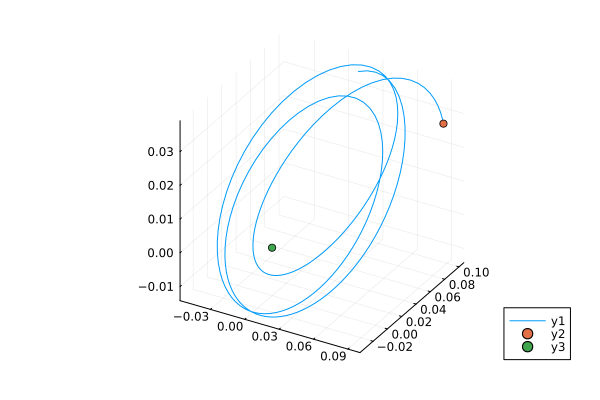

In [40]:
plot(all_states[1,:], all_states[2,:], all_states[3,:]) 
scatter!([all_states[1,1]], [all_states[2,1]], [all_states[3,1]])
scatter!([0], [0], [0])

In [41]:
zeros(size(all_states))

6×243 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [55]:
#convert all states onto rotating frame
all_states_converted = zeros(size(all_states))

for i=1:size(all_states)[2]

    C, θ_dot = get_transformation(sol.t[i]*t_star)

    C̄ = [θ_dot.*C[:,2] -θ_dot.*C[:,1]]

    #transformation matrix
    C̃ = [C zeros(3,3); C̄ zeros(3) C]

    all_states_scaled = [all_states[1:3, i]*l_star; all_states[4:6, i]*(l_star/t_star)]

    all_states_converted[:,i] = C̃'*all_states_scaled

end

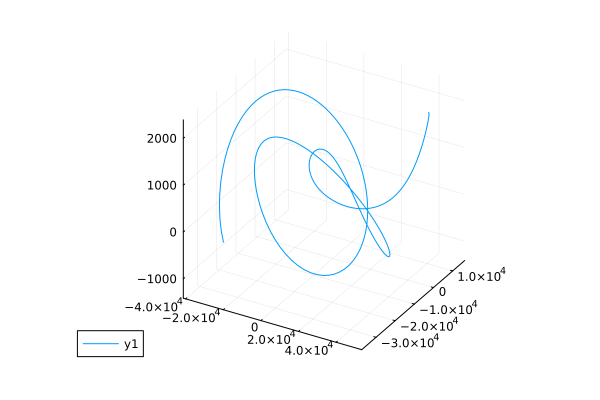

In [56]:
plot(all_states_converted[1,:], all_states_converted[2,:], all_states_converted[3,:])
scatter!([all_states_converted[1,1]], [all_states_converted[2,1]], [all_states_converted[3,:]])

In [47]:
using DelimitedFiles
xtraj  = readdlm("xtraj.txt", '\t', Float64, '\n')

#in days
time_steps = readdlm("time.txt", '\t', Float64, '\n')
#period 
T_periodic_n = 3.414975413662902

3.414975413662902

In [ ]:
(1-μ_earth_moon)*L_cr 

In [ ]:
xtraj_transformed = [xtraj[1:3, :].-[380322.0245402948, 0, 0]; xtraj[4:6, :]./86400]

In [ ]:
#transform each of these points into the Earth Moon ephemeris model to see what it looks like

xtraj_ephemeris = zeros(6,131)

x_centered = xtraj_ephemeris 

for i=1:131

    xtraj_ephemeris[:,i] = cr3bp_to_ephem(xtraj_transformed[:,i], time_steps[i]*86400)
end

In [ ]:
all_states[1:3]*L_cr 

In [ ]:
xtraj_ephemeris

In [ ]:
[all_states[1:3,:]*l_star; all_states[4:6, :]*(l_star/t_star)]

In [ ]:
plot(xtraj_ephemeris[1,:], xtraj_ephemeris[2,:], xtraj_ephemeris[3,:])

plot!(all_states[1,:]*l_star, all_states[2,:]*l_star, all_states[3,:]*l_star) 
scatter!([all_states[1,1]*l_star], [all_states[2,1]*l_star], [all_states[3,1]*l_star])
scatter!([0], [0], [0])

In [ ]:
#do get a periodic orbit with my initial condition. Convert the solution in ephemeris to 
#the moon rotating state in order to compare with the cr3bp solution